In [396]:
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter

In [397]:
#Load the Iris data file using python csv module
data = open('iris.csv')
dataReader = csv.reader(data)

# irisData: List to hold the iris data
irisData = []
for row in dataReader:
    irisData.append([float(row[0]), float(row[1]), float(row[2]), float(row[3]), row[4]])

In [398]:
# Split the data into training and testing sets
# The training set will contain 80% of the data, the testing set will contain 20% of the data
# data: file data; ranNum: ensures reproducibilty; trainKnn: resulting data set for training; testKnn: resulting data set for testing 
def split(data, ranNum):
    trainKnn, testKnn = sklearn.model_selection.train_test_split(data, train_size = 0.8, test_size = 0.2, shuffle = True, random_state = ranNum)
    return trainKnn, testKnn

In [399]:
###############################################################################################################################################

# Normalization Helper Functions

# Normalize a column of data using the maximum and minimum values
# col: column to be normalized; maxVal: maximum value in the column; minVal: minimum value in the column, resArr: resulting normalized array
def normalizationMaxMin(col, maxVal, minVal):
    # iterate through the list and normalize each value
    resArr = [(val - minVal) / (maxVal - minVal) for val in col] 
    return resArr

# Normalize a column of data
# col: column to be normalized; resArr: resulting normalized array
def normalization(col):
    minVal = min(col)
    maxVal = max(col)
    # iterate through the list and normalize each value
    resArr = [(val - minVal) / (maxVal - minVal) for val in col]
    return resArr, minVal, maxVal

# Normalize the training and testing datasets using the maximum and minimum values
# trainData: training dataset; testData: the testing dataset
def normalizedDataset(trainData, testData):
    trainKnnNorm = []
    testKnnNorm = []
    i = 0
    # Loop through each column in the training dataset
    for col in trainData:
        trainArr = []
        testArr = []
        # Check if the current column is a feature column (i.e. columns 0-3)
        if i < 4:
            trainArr, trainMin, trainMax = normalization(col)
            # Normalize the testing data for the current column using the minimum and maximum values from the training data
            testArr = normalizationMaxMin(testData[i], trainMax, trainMin)
            trainKnnNorm.append(trainArr)
            testKnnNorm.append(testArr)
            i += 1
    # Append the unnormalized labels (i.e. the species column) to the normalized training and testing datasets
    trainKnnNorm.append(trainData[4])
    testKnnNorm.append(testData[4])
    return trainKnnNorm, testKnnNorm

# Transpose a 2D array
# arr: array to be transposed
def transpose(arr):
    return [list(row) for row in zip(*arr)]

###############################################################################################################################################

# Normalize the training and testing datasets
# trainData: the training dataset; testData: the testing dataset
def normflow(trainData, testData):
    # transpose the training and testing datasets
    ttrainData = transpose(trainData)
    ttestData = transpose(testData)
    # normalize the transposed data
    normttrainData, normttestData = normalizedDataset(ttrainData, ttestData)
    # transpose the normalized training and testing datasets back to their original format
    resNormTrain, resNormTest = transpose(normttrainData), transpose(normttestData)
    return resNormTrain, resNormTest

In [400]:
# Euclidean distance
# Compute the elcudidean distance between two arrays
def euclideanDist(arr1, arr2):
    arr1 = np.array(arr1)
    arr2 = np.array(arr2)
    dist = np.linalg.norm(arr1 - arr2)
    return dist

# Computethe Euclidean distance between a test data point and all the training data points
# testDataPt: test data point; trainDataPt: a list of training data points
def distanceCalc(testDataPt, trainDataPts):
    # feature values of the test data point
    pt1 = testDataPt[:-1]
    # calculate the Euclidean distance between the test data point and all the training data points
    distArr = [(euclideanDist(pt1, elem[:-1]), elem[-1]) for elem in trainDataPts]
    # return distances in ascending order
    return sorted(distArr, key=itemgetter(0))

###############################################################################################################################################
#KNN Helper Functions

# k-nearest neighbours algorithm
# k: number of nearest neighbours being considered; trainData: training data set; testData: testing data set
def knn(k, trainData, testData):
    predictedLables = []
    # extract the true labels for test data and store them in a separate list
    correctLables = [col[-1] for col in testData]
    for datpt in testData:
        distlist = distanceCalc(datpt, trainData)
        # extract the labels of the k nearest neighbours
        catlist = [col[1] for col in distlist[:k]]
        # predict the label of the test data point based on the majority label of k nearest neighbours
        predictedLables.append(max(set(catlist), key=catlist.count))
    return predictedLables, correctLables

# accuracy of the predicted labels generated by the knn function above
# predicted: predicted labels for test data points; correct: correct labels for test data points
def accuracy(predicted, correct):
    total = len(predicted)
    # count the number of correct predictions
    correctLables = sum(1 for i in range(total) if predicted[i] == correct[i])
    return correctLables / total

###############################################################################################################################################

# performs k-fold cross-validation to test the accuracy of the knn() function using a given value of k on the training dataset.
# k = number of neighbours; randNum: number used to split dataset; data: iris data
def accuracyTrainData(k, randNum, data):
    # split the dataset
    trainknn, testknn = split(data, randNum)
    #normalize the dataset (comment out for Q1.6 to test on unnormalized data)
    # normedtrain, normedtest = normflow(trainknn, testknn)
    normedtrain, normedtest = trainknn, testknn
    # predict labels for the training set using the knn function with k nearest neighbors
    predictedLables, correctLables = knn(k, normedtrain, normedtrain)
    calcAccuracy = accuracy(predictedLables, correctLables)
    return calcAccuracy

# performs k-fold cross-validation to test the accuracy of the knn() function using a given value of k on the testing dataset.
# k = number of neighbours; randNum: number used to split dataset; data: iris data
def accuracyTestData(k, randNum, data):
    # split the dataset
    trainknn, testknn = split(data, randNum)
    #normalize the dataset (comment out for Q1.6 to test on unnormalized data)
    # normedtrain, normedtest = normflow(trainknn, testknn)
    normedtrain, normedtest = trainknn, testknn
    # predict labels for the testing set using the knn function with k nearest neighbors
    predictedLables, correctLables = knn(k, normedtrain, normedtest)
    calcAccuracy = accuracy(predictedLables, correctLables)
    return calcAccuracy

In [401]:
# performs statistical analysis on the accuracy of the knn() function using a range of k values on a dataset
#  data: iris data set
def statAnalysisAccTrain(data):
    k = 1
    # list to store the results for each k value
    caclKVals = []
    while k <= 51:
        randNum = 12100
        # empty list to store the accuracy results for each random seed
        calcAccVals = []
        while randNum < 12200:
            # calculate the accuracy of the knn function using k-fold cross-validation with a given k value and random seed value
            calcAccVals.append(accuracyTrainData(k, randNum, data))
            # for each value of k, run the process 20 times.
            randNum += 5
        caclKVals.append(calcAccVals)
        # varying k from 1 to 51, using only odd numbers
        k+=2
    
    return np.array(caclKVals)

# performs statistical analysis on the accuracy of the knn() function using a range of k values on a dataset
#  data: iris data set
def statAnalysisAccTest(data):
    k = 1
    # list to store the results for each k value
    caclKVals = []
    while k <= 51:
        randNum = 12100
        # empty list to store the accuracy results for each random seed
        calcAccVals = []
        while randNum < 12200:
            # calculate the accuracy of the knn function using k-fold cross-validation with a given k value and random seed value
            calcAccVals.append(accuracyTestData(k, randNum, data))
            # for each value of k, run the process 20 times.
            randNum += 5 
        # append the accuracy results for the current k value to the result list
        caclKVals.append(calcAccVals)
        # varying k from 1 to 51, using only odd numbers
        k += 2
    return np.array(caclKVals)

In [402]:
# NumPy array k that contains odd integer values from 1 to 51 
k = np.arange(1,52,2)

#RESULTS
kValsTrain = statAnalysisAccTrain(irisData)
kValsTest = statAnalysisAccTest(irisData)

#Accuracy for training dataset
accValsTrain = kValsTrain.mean(axis=1)
# print("KNN accuracy for training set")
# print(accValsTrain)

#Accuracy for testing dataset
accValsTest = kValsTest.mean(axis=1)
# print("KNN accuracy for testing set")
# print(accValsTest)

# Std deviation for training
stdValsTrain = kValsTrain.std(axis = 1)
# print("KNN standard deviation for training")
# print(stdValsTrain)

stdValsTest = kValsTest.std(axis = 1)
# print("KNN standard deviation for training")
# print(stdValsTest)

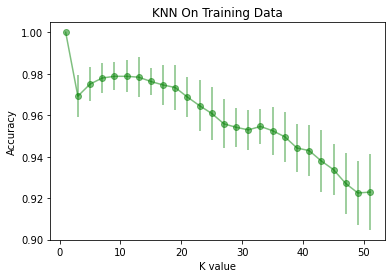

In [403]:
# Q1.1
plt.errorbar(k, accValsTrain, yerr = stdValsTrain, fmt = "-o", color = 'green', alpha = 0.5)
plt.title("KNN On Training Data")
plt.xlabel("K value")
plt.ylabel("Accuracy")
plt.show()

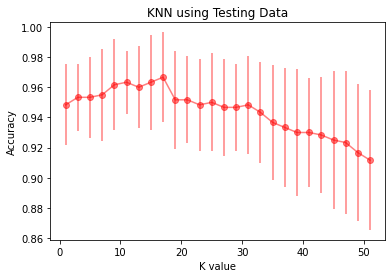

In [404]:
# Q1.2
plt.errorbar(k, accValsTest, yerr = stdValsTest, fmt = "-o", color = 'red', alpha = 0.5)
plt.title("KNN using Testing Data")
plt.xlabel("K value")
plt.ylabel("Accuracy")
plt.show()

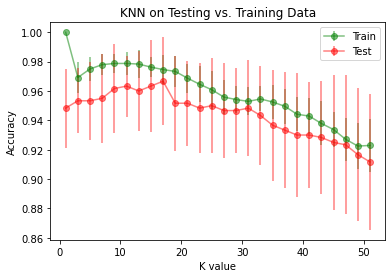

In [405]:
plt.errorbar(k, accValsTrain, yerr = stdValsTrain, fmt = "-o", color = 'green', alpha = 0.5, label= "Train")
plt.errorbar(k, accValsTest, yerr = stdValsTest, fmt = "-o", color = 'red', alpha = 0.5, label= "Test")
plt.legend()
plt.title("KNN on Testing vs. Training Data")
plt.xlabel("K value")
plt.ylabel("Accuracy")
plt.show()

In [406]:
# WITH NORMALIZATION:

# KNN accuracy for training set
# [1.         0.96791667 0.9675     0.97458333 0.97208333 0.9725
#  0.97375    0.9725     0.97083333 0.96541667 0.96416667 0.96125
#  0.96083333 0.96083333 0.96125    0.95708333 0.95458333 0.94625
#  0.94208333 0.93541667 0.93       0.9225     0.915      0.91
#  0.9075     0.90583333]

# KNN accuracy for testing set
# [0.94333333 0.94166667 0.955      0.94666667 0.94833333 0.95166667
#  0.955      0.95666667 0.95666667 0.95166667 0.94833333 0.95333333
#  0.94666667 0.945      0.94333333 0.94166667 0.94166667 0.94
#  0.93666667 0.93166667 0.91833333 0.91166667 0.90833333 0.9
#  0.89833333 0.89      ]

# KNN standard deviation for training
# [0.         0.00605243 0.00829156 0.01036655 0.00660124 0.0083749
#  0.00844714 0.01057381 0.00931695 0.01029934 0.00794949 0.00844714
#  0.00650854 0.00595119 0.00844714 0.00844714 0.00767165 0.01002601
#  0.00892679 0.01114145 0.01452966 0.01493039 0.0163724  0.01982563
#  0.02122957 0.01808545]
 
# KNN standard deviation for training
# [0.03511885 0.02327373 0.02420973 0.0244949  0.02682246 0.02466441
#  0.02420973 0.01855921 0.02603417 0.03244654 0.03068659 0.0305505
#  0.03231787 0.03032234 0.03       0.03312434 0.03476109 0.03741657
#  0.04068852 0.04530759 0.04884784 0.05403188 0.05361903 0.0505525
#  0.05320297 0.05487359]

# WITHOUT NORMALIZATION:

# KNN accuracy for training set
# [1.         0.96916667 0.975      0.97791667 0.97875    0.97875
#  0.97833333 0.97625    0.97458333 0.97333333 0.96875    0.96458333
#  0.96083333 0.95583333 0.95416667 0.95291667 0.95458333 0.9525
#  0.94958333 0.94416667 0.94291667 0.93791667 0.93375    0.92708333
#  0.9225     0.92291667]
# KNN accuracy for testing set
# [0.94833333 0.95333333 0.95333333 0.955      0.96166667 0.96333333
#  0.96       0.96333333 0.96666667 0.95166667 0.95166667 0.94833333
#  0.95       0.94666667 0.94666667 0.94833333 0.94333333 0.93666667
#  0.93333333 0.93       0.93       0.92833333 0.925      0.92333333
#  0.91666667 0.91166667]
# KNN standard deviation for training
# [0.         0.01024017 0.00833333 0.0071078  0.00670562 0.00767165
#  0.00964653 0.00660124 0.00967349 0.01073675 0.00981602 0.01232517
#  0.01293681 0.01181454 0.00931695 0.00960143 0.00852895 0.0115169
#  0.01192424 0.0115169  0.01243734 0.01501735 0.01221196 0.01464274
#  0.01538849 0.01823363]
# KNN standard deviation for training
# [0.02682246 0.02211083 0.02666667 0.03032234 0.03032234 0.02081666
#  0.02708013 0.0314466  0.02981424 0.03244654 0.02881936 0.03068659
#  0.03248931 0.03231787 0.02867442 0.03244654 0.03349959 0.03785939
#  0.03944053 0.04203173 0.03636237 0.03840573 0.04579544 0.04725816
#  0.04533824 0.04627814]